# Smart News Analyzer

##### Import Useful Library

In [1]:
import os
import re
import spacy
import zipfile
import requests
import warnings
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv1D, GlobalMaxPooling1D

from transformers import logging
from transformers import TFAutoModel, AutoTokenizer
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
logging.set_verbosity_error()

import torch; print(torch.version.cuda); print(torch.cuda.is_available())

10.2
True


##### Load the data
Consists of Class Index 1-4 where 
<br>1-World, 
<br>2-Sports, 
<br>3-Business, 
<br>4-Sci/Tech

In [2]:
# Train data
data_train = pd.read_csv(r'Dataset/AG News Classification Dataset/train.csv')
data_test = pd.read_csv(r'Dataset/AG News Classification Dataset/test.csv')

print('Shape of Train Data: ', data_train.shape)
print('Shape of Test Data:  ', data_test.shape)

data_train.head()

Shape of Train Data:  (120000, 3)
Shape of Test Data:   (7600, 3)


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


### Exploratory Data Analysis (EDA)
Side-by-Side Bar Chart representing the count of records in each class

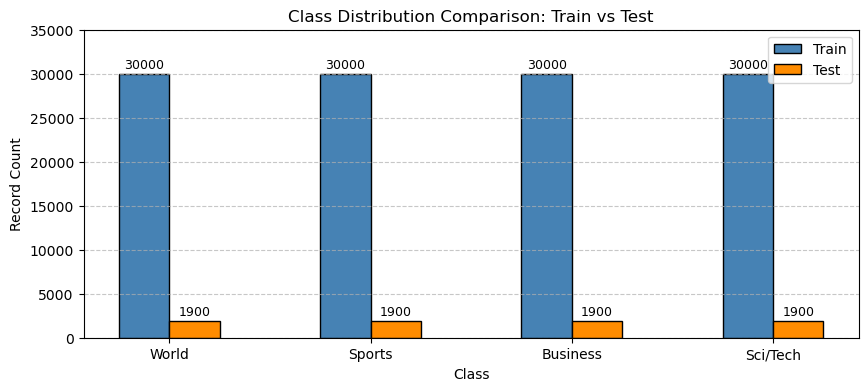

In [3]:
train_counts = data_train['Class Index'].value_counts().sort_index()
test_counts = data_test['Class Index'].value_counts().sort_index()

class_map = {1: 'World', 2: 'Sports', 3: 'Business', 4: 'Sci/Tech'}
labels = [class_map[i] for i in train_counts.index]
x = np.arange(len(labels))
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(10, 4))
bars1 = ax.bar(x - width/2, train_counts, width, label='Train', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_counts, width, label='Test', color='darkorange', edgecolor='black')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 300, str(bar.get_height()),
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 300, str(bar.get_height()),
            ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Class')
ax.set_ylabel('Record Count')
ax.set_title('Class Distribution Comparison: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 35000])
ax.legend(loc="upper right")
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Data Preprocessing

###### 1) Basic Cleaning for training and testing data
Remove HTML tags and punctuation, convert to lowercase

In [4]:
def clean_text(text):
    text = re.sub(r'<.*?>','', text)
    text = re.sub(r'[^a-zA-Z0-9\s]','', text)
    return text.lower().strip()

data_train["clean_body"] = data_train.Description.map(clean_text)
data_test["clean_body"] = data_test.Description.map(clean_text)
data_train[['clean_body']].head()

,clean_body
0,reuters shortsellers wall streets dwindlingba...
1,reuters private investment firm carlyle group...
2,reuters soaring crude prices plus worriesabou...
3,reuters authorities have halted oil exportflo...
4,afp tearaway world oil prices toppling record...


###### 2) Tokenization & Lemmatization (spacy)
Preprocesses text data by loading a spaCy English model with parser and named entity recognition disabled for efficiency. 
<br>Tokenizes input text, removes stopwords, and converts words to their base form.

In [5]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def tokenize_lemmatize_batch(texts):
    tokens_list = []
    for doc in nlp.pipe(texts, batch_size=50, n_process=2):
        tokens = [tok.lemma_.strip() for tok in doc if not tok.is_stop and not tok.is_punct and tok.lemma_.strip()]
        tokens_list.append(tokens)
    return tokens_list

data_train["tokens"] = tokenize_lemmatize_batch(data_train["clean_body"].fillna("").astype(str))
data_test["tokens"] = tokenize_lemmatize_batch(data_test["clean_body"].fillna("").astype(str))
data_train[['tokens']].head()

,tokens
0,"[reuters, shortseller, wall, streets, dwindlin..."
1,"[reuters, private, investment, firm, carlyle, ..."
2,"[reuters, soar, crude, price, plus, worriesabo..."
3,"[reuters, authority, halt, oil, exportflow, ma..."
4,"[afp, tearaway, world, oil, price, topple, rec..."


###### 3)  Sequence Padding, and Train-Validation Split

In [6]:
texts_train = data_train['tokens'].apply(lambda x: " ".join(x)).tolist()
texts_test = data_test['tokens'].apply(lambda x: " ".join(x)).tolist()

# Initialize Tokenizer and fit on training texts only
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train)

# Save the tokenizer to JSON
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)

# Convert tokens to sequences of integers
sequences_train = tokenizer.texts_to_sequences(texts_train)

# Calculate 95th percentile sequence length for padding
lengths = [len(seq) for seq in sequences_train]
max_len = int(np.percentile(lengths, 95))  # dynamically set max_len

# Pad sequences to this dynamic max length
padded_train = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')

# Train-validation split
y = data_train['Class Index'].values - 1
X_train, X_val, y_train, y_val = train_test_split(padded_train, y, test_size=0.2, stratify=y, random_state=42)

# ***News Classifier =========================***

### Define model architectures and train each model

###### 1) BiLSTM Model (Baseline RNN-based model)

In [7]:
# Download GloVe if not already downloaded
def download_glove(dest_path='glove.6B.zip', extract_path='.'):
    if not os.path.exists('glove.6B.100d.txt'):
        url = 'http://nlp.stanford.edu/data/glove.6B.zip'
        print("Downloading GloVe embeddings...")
        response = requests.get(url)
        with open(dest_path, 'wb') as f:
            f.write(response.content)
        print("Extracting GloVe...")
        with zipfile.ZipFile(dest_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        os.remove(dest_path)
        print("GloVe ready.")

download_glove()

# Load embeddings into matrix
def load_glove_embeddings(glove_path, tokenizer, embedding_dim=100, num_words=10000):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i < num_words and word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Prepare embedding matrix
glove_path = 'glove.6B.100d.txt'
embedding_dim = 100
num_words = min(10000, len(tokenizer.word_index) + 1)
embedding_matrix = load_glove_embeddings(glove_path, tokenizer, embedding_dim, num_words)

# Define BiLSTM model
def build_bilstm_model():
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len,
                  weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    return model

bilstm_model = build_bilstm_model()
bilstm_model.summary()
print('')

# Compile the model
bilstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bilstm_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,092,996
Trainable params: 92,996
Non-trainable params: 1,000,000
_________________________________________________________________

Epoch 1/20
3000/3000 [==============================] - 57s 18ms/step - loss: 0.3611 - accuracy: 0.8728 - 

###### 2) CNN Model (Baseline CNN-based model)

In [8]:
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_len,
                  weights=[embedding_matrix], trainable=False),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
    ])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()
print('')

# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 100)           1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 24, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 1,072,644
Trainable params: 72,644
Non-trainable params: 1,000,000
_______________________________________

###### 3) Fine-Tuned BERT Model (Advanced Transformer-based model)

In [9]:
def build_bert_model():
    bert_model = TFAutoModel.from_pretrained("bert-base-uncased")
    input_ids = tf.keras.Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    cls_output = outputs.last_hidden_state[:, 0, :]
    x = Dropout(0.3)(cls_output)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

bert_model = build_bert_model()
bert_model.summary()
print('')

# Prepare split
X_idx = np.arange(len(texts_train))
X_train_idx, X_val_idx, y_train, y_val = train_test_split(X_idx, y, test_size=0.2, stratify=y, random_state=42)
texts_train_split = [texts_train[i] for i in X_train_idx]
texts_val_split = [texts_train[i] for i in X_val_idx]

# Select subset of training and validation data
subset_size = 1000
texts_train_subset = texts_train_split[:subset_size];            y_train_subset = y_train[:subset_size]
texts_val_subset = texts_val_split[:int(0.2 * subset_size)];     y_val_subset = y_val[:int(0.2 * subset_size)]

# Tokenize with Hugging Face tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Encodings
train_encod = bert_tokenizer(texts_train_subset, truncation=True, padding='max_length', max_length=128, return_tensors='tf')
val_encod = bert_tokenizer(texts_val_subset, truncation=True, padding='max_length', max_length=128, return_tensors='tf')

X_train_input_ids = train_encod['input_ids'];    X_train_attention_mask = train_encod['attention_mask']
X_val_input_ids = val_encod['input_ids'];        X_val_attention_mask = val_encod['attention_mask']

# Compile the model
bert_model.compile(optimizer=Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bert_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history_bert = bert_model.fit(
    x={'input_ids': X_train_input_ids, 'attention_mask': X_train_attention_mask},
    y=y_train_subset,
    validation_data=({'input_ids': X_val_input_ids, 'attention_mask': X_val_attention_mask}, y_val_subset),
    epochs=20,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_bert_model[0][0]          

### Evaluation

###### 1) Load Pretrained Models

In [10]:
# Load BiLSTM and CNN models
bilstm_model = load_model('bilstm_model.h5')
cnn_model = load_model('cnn_model.h5')

# Load BERT model using custom objects
def build_bert_model():
    bert_model = TFAutoModel.from_pretrained("bert-base-uncased")
    input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    cls_output = outputs.last_hidden_state[:, 0, :]
    x = Dropout(0.3)(cls_output)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

bert_model = build_bert_model()
bert_model.load_weights("bert_model.h5")

###### 2) Prepare Test Data

In [11]:
# For BiLSTM and CNN
X_test_bilstm_cnn = tokenizer.texts_to_sequences(texts_test)
X_test_bilstm_cnn = pad_sequences(X_test_bilstm_cnn, maxlen=max_len, padding='post', truncating='post')

# For BERT
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
test_encod = bert_tokenizer(texts_test, truncation=True, padding='max_length', max_length=128, return_tensors='tf')
X_test_input_ids = test_encod['input_ids']
X_test_attention_mask = test_encod['attention_mask']
pred_probs = bert_model.predict({'input_ids': X_test_input_ids, 'attention_mask': X_test_attention_mask}, 
                                batch_size=32, verbose=1)

# Actual Labels of Test set
y_test = data_test['Class Index'].values - 1

238/238 [==============================] - 737s 3s/step


###### 3) Classification Reports

In [12]:
# BiLSTM Evaluation
y_pred_bilstm = np.argmax(bilstm_model.predict(X_test_bilstm_cnn), axis=1)
print("BiLSTM Classification Report:")
print(classification_report(y_test, y_pred_bilstm, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

# CNN Evaluation
y_pred_cnn = np.argmax(cnn_model.predict(X_test_bilstm_cnn), axis=1)
print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

# BERT Evaluation
y_pred_bert = tf.argmax(pred_probs, axis=1).numpy()
print("\nBERT Classification Report:")
print(classification_report(y_test, y_pred_bert, target_names=['World', 'Sports', 'Business', 'Sci/Tech']))

BiLSTM Classification Report:
              precision    recall  f1-score   support

       World       0.94      0.90      0.92      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.88      0.87      0.87      1900
    Sci/Tech       0.87      0.88      0.87      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


CNN Classification Report:
              precision    recall  f1-score   support

       World       0.92      0.88      0.90      1900
      Sports       0.95      0.96      0.96      1900
    Business       0.86      0.85      0.85      1900
    Sci/Tech       0.85      0.88      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600


BERT Classification Report:
              precision    recall  f1-score

###### 4) Confusion Matrices

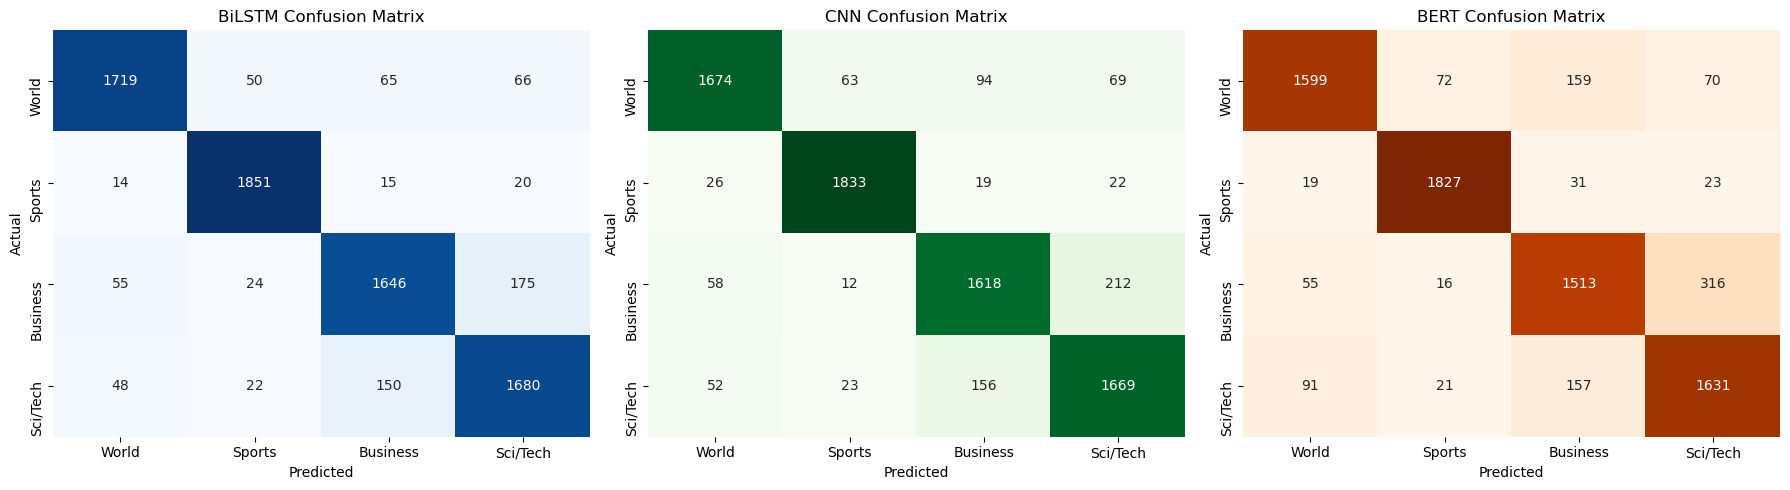

In [13]:
# Compute confusion matrices
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
cm_bert = confusion_matrix(y_test, y_pred_bert)

# Labels
labels = ['World', 'Sports', 'Business', 'Sci/Tech']

# Setup plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['BiLSTM Confusion Matrix', 'CNN Confusion Matrix', 'BERT Confusion Matrix']
cms = [cm_bilstm, cm_cnn, cm_bert]
colormaps = ['Blues', 'Greens', 'Oranges']  # Different colormaps

# Plot each confusion matrix with a different color
for ax, cm, title, cmap in zip(axes, cms, titles, colormaps):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax, xticklabels=labels, yticklabels=labels, cbar=False)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

###### 5) Comparison

In [14]:
acc_bilstm = accuracy_score(y_test, y_pred_bilstm)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
acc_bert = accuracy_score(y_test, y_pred_bert)

accuracy_comparison_df = pd.DataFrame({'BiLSTM': [acc_bilstm], 'CNN': [acc_cnn], 'BERT': [acc_bert]}, index=['Accuracy'])
accuracy_comparison_df = accuracy_comparison_df.round(3)
accuracy_comparison_df.head()

,BiLSTM,CNN,BERT
Accuracy,0.907,0.894,0.864


# ***Headline Generator =========================***

###### 1) Load PEGASUS Model
Using google/pegasus-xsum which is fine-tuned for short, concise summaries (good for headlines)

In [15]:
def load_pegasus_model(model_name="google/pegasus-xsum"):
    """Load the PEGASUS tokenizer and model."""
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)
    return tokenizer, model

# Load model and tokenizer
pegasus_tokenizer, pegasus_model = load_pegasus_model()

###### 2) Generate Headline

In [16]:
def generate_headline(article_text, tokenizer, model):
    # Prepare the text input
    inputs = tokenizer(article_text, max_length=512, truncation=True, return_tensors="pt")
    # Generate the headline
    with torch.no_grad():
        summary_ids = model.generate(
            inputs["input_ids"],
            min_length=5,
            num_beams=4,
            length_penalty=1.0,
            early_stopping=True
        )
    # Decode the generated headline
    headline = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return headline

# Generate headline per random class/category
print("--- Headline Generation per Category ---")
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']
for class_idx, class_name in enumerate(class_labels, start=1):
    class_articles = data_test[data_test['Class Index'] == class_idx]
    sample = class_articles.sample(1).iloc[0]
    article_text = sample['Description']
    print(f"\nCategory: {class_name}")
    print(f"Article Preview: {article_text[:100]}...")
    print(f"Generated Headline: {generate_headline(article_text, pegasus_tokenizer, pegasus_model)}")

--- Headline Generation per Category ---

Category: World
Article Preview: NEW DELHI, Aug. 25. - Kuwait has promised to leave no stone unturned to ensure the safe return of th...
Generated Headline: Kuwait's Foreign Minister Sheikh Sabah al-Ahmad al-Jaber al-Sabah has arrived in India for talks on the hostage crisis in Iraq.

Category: Sports
Article Preview: Tyler Hamilton, who won an Olympic gold medal for the United States in Athens, was fired last Thursd...
Generated Headline: A former Olympic champion has been provisionally suspended by the World Anti-Doping Agency after testing positive for a banned substance.

Category: Business
Article Preview:  LONDON (Reuters) - U.S. Treasury prices rose on Friday,  with a rally in Japanese government bond (...
Generated Headline: US government bond prices were little changed on the day, with the benchmark 10-year note trading flat on the day.

Category: Sci/Tech
Article Preview: While the Bush administration's words of support for a high-tec

# ***Classification and Headline Generation of Unknown Articles =====***

##### 1) Article Classification

In [22]:
def classify_article(article_text):
    # Predict with BiLSTM and CNN
    seq = tokenizer.texts_to_sequences([article_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    bilstm_probs = bilstm_model.predict(padded_seq)
    cnn_probs = cnn_model.predict(padded_seq)
    
    # Predict with BERT
    bert_encod = bert_tokenizer(article_text, truncation=True, padding='max_length', max_length=128, return_tensors='tf')
    bert_probs = bert_model.predict({'input_ids': bert_encod['input_ids'], 'attention_mask': bert_encod['attention_mask']})
    
    # Find max confidence and predicted class for each model
    bilstm_confidence = np.max(bilstm_probs)
    bilstm_pred = np.argmax(bilstm_probs)
    cnn_confidence = np.max(cnn_probs)
    cnn_pred = np.argmax(cnn_probs)
    bert_confidence = np.max(bert_probs)
    bert_pred = tf.argmax(bert_probs, axis=1).numpy()[0]
    
    # Find which model has the best confidence
    confidences = [bilstm_confidence, cnn_confidence, bert_confidence]
    preds = [bilstm_pred, cnn_pred, bert_pred]
    model_names = ['BiLSTM', 'CNN', 'BERT']
    
    best_idx = np.argmax(confidences)
    
    # Map index to class name
    class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
    best_model = model_names[best_idx]
    best_class = class_names[preds[best_idx]]
    best_score = confidences[best_idx]
    
    return {'model': best_model, 'predicted_class_index': preds[best_idx]+1, 'confidence_score': best_score}

###### 2) Display Headline

In [23]:
def display_headline(article_text, original_class, generated_headline):
    class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']
    class_name = class_labels[original_class - 1]
    display(Markdown(f"""
### 🗂️ **Category:** `{class_name}`  
### 📄 **Article Preview:**  
> {article_text[:500]}...
### 📰 **Generated Headline**
**{generated_headline}**
---
"""))

###### 3) Examples

In [24]:
article1 = """
Global markets reacted positively today as major tech companies reported 
stronger-than-expected quarterly earnings. Investors were particularly encouraged by 
increased revenue from cloud services and digital advertising. Analysts predict this 
trend could boost the overall economy in the coming months, signaling a robust recovery 
despite ongoing geopolitical tensions.
"""

print(classify_article(article1))
display_headline(
    article1, 
    classify_article(article1)['predicted_class_index'], 
    generate_headline(article1, pegasus_tokenizer, pegasus_model)
)

{'model': 'CNN', 'predicted_class_index': 3, 'confidence_score': 0.7450338}



### 🗂️ **Category:** `Business`  
### 📄 **Article Preview:**  
> 
Global markets reacted positively today as major tech companies reported 
stronger-than-expected quarterly earnings. Investors were particularly encouraged by 
increased revenue from cloud services and digital advertising. Analysts predict this 
trend could boost the overall economy in the coming months, signaling a robust recovery 
despite ongoing geopolitical tensions.
...
### 📰 **Generated Headline**
**The Dow Jones and S&P 500 both closed at record highs on Wednesday.**
---


In [25]:
article2 = """
Scientists have discovered a new species of deep-sea fish that can withstand 
extreme pressure at depths of up to 8,000 meters. The discovery was made during 
an expedition to the Mariana Trench, the deepest part of the world's oceans. 
Researchers say the fish has unique adaptations that allow it to survive in one 
of the most hostile environments on Earth.
"""

print(classify_article(article2))
display_headline(
    article2, 
    classify_article(article2)['predicted_class_index'], 
    generate_headline(article2, pegasus_tokenizer, pegasus_model)
)

{'model': 'CNN', 'predicted_class_index': 4, 'confidence_score': 0.9750846}



### 🗂️ **Category:** `Sci/Tech`  
### 📄 **Article Preview:**  
> 
Scientists have discovered a new species of deep-sea fish that can withstand 
extreme pressure at depths of up to 8,000 meters. The discovery was made during 
an expedition to the Mariana Trench, the deepest part of the world's oceans. 
Researchers say the fish has unique adaptations that allow it to survive in one 
of the most hostile environments on Earth.
...
### 📰 **Generated Headline**
**A new species of deep-sea fish has been discovered during an expedition to the Mariana Trench in the Pacific Ocean.**
---


# ***Streamlit App =============================***

In [ ]:
code = """
import os
import streamlit as st
import warnings
warnings.filterwarnings("ignore")

import gdown
import numpy as np
import torch; print(torch.version.cuda); print(torch.cuda.is_available())

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model

from transformers import AutoTokenizer, TFAutoModel, PegasusTokenizer, PegasusForConditionalGeneration

# Page configuration
st.set_page_config(page_title="Smart News Analyzer", page_icon="🧠", layout="centered")

# Intergalactic-Themed Cyber UI
st.markdown(\"\"\"
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Share+Tech+Mono&display=swap');

        html, body, [class*="css"]  {
            font-family: 'Share Tech Mono', monospace;
            background: radial-gradient(ellipse at bottom, #0f0f2a 0%, #000000 80%);
            color: #ffffff;
        }

        .main {
            background-color: #121212;
            border-radius: 18px;
            padding: 3rem 2rem;
            box-shadow: 0 0 40px rgba(255, 0, 0, 0.3);
        }

        .animated-title span {
            display: inline-block;
            opacity: 0;
            color: #ff3131;
            text-shadow: 0 0 10px #ff0000, 0 0 20px #ff5e5e, 0 0 30px #ff0000;
            animation: bounceIn 0.6s forwards;
        }

        .animated-title {
            font-size: 2.8rem;
            letter-spacing: 2px;
            text-align: center;
            margin-bottom: 10px;
            font-family: 'Share Tech Mono', monospace;
        }

        .animated-subtext {
            color: #3e7de1;
            font-size: 20px;
            text-align: center;
            opacity: 0;
            animation: riseUp 1.5s ease-out 2s forwards;
            font-family: 'Share Tech Mono', monospace;
            text-shadow: 0 0 6px #3e7de1, 0 0 12px #3e7de1;
            text-transform: uppercase;
            letter-spacing: 1px;
        }

        @keyframes bounceIn {
            to {
                opacity: 1;
                transform: translateY(0);
            }
        }

        @keyframes riseUp {
            0% { transform: translateY(40px); opacity: 0; }
            100% { transform: translateY(0); opacity: 1; }
        }

        .stTextArea label,
        .stSlider label {
            color: #0ea5e9 !important;
            font-family: 'Share Tech Mono', monospace;
            font-size: 16px !important;
            text-transform: uppercase;
            letter-spacing: 1px;
        }

        .stTextArea textarea {
            background-color: #1e1e1e;
            border: 3px solid transparent;
            border-radius: 12px;
            color: #ffffff;
            padding: 1rem;
            font-size: 16px;
            font-family: 'Share Tech Mono', monospace;
            background-image: linear-gradient(#1e1e1e, #1e1e1e), linear-gradient(90deg, #00ffff, #ff00ff, #00ffff);
            background-origin: border-box;
            background-clip: padding-box, border-box;
            animation: borderAnimation 4s linear infinite;
        }

        @keyframes borderAnimation {
            0% {
                background-position: 0 0;
            }
            100% {
                background-position: 400% 0;
            }
        }

        .stButton > button {
            background-color: #39ff14;
            color: white;
            font-weight: 700;
            border-radius: 12px;
            font-size: 16px;
            animation: pulse 2s infinite;
            border: none;
            font-family: 'Share Tech Mono', monospace;
        }

        @keyframes pulse {
            0% { box-shadow: 0 0 0 0 rgba(57, 255, 20, 0.7); }
            70% { box-shadow: 0 0 0 10px rgba(57, 255, 20, 0); }
            100% { box-shadow: 0 0 0 0 rgba(57, 255, 20, 0); }
        }
    </style>
\"\"\", unsafe_allow_html=True)

# Animated title
st.markdown('<div class="animated-title"><span>🧠 Smart News Analyzer</span></div>', unsafe_allow_html=True)
st.markdown('<div class="animated-subtext">Classify News. Generate Headlines. Stay Smart.</div>', unsafe_allow_html=True)

# Constants
GOOGLE_DRIVE_FILES = {
    "bilstm_model.h5": "1Js-MS8K8kWT23STTrYo9WizRpdr2qcYL",
    "cnn_model.h5": "1mUgDlby6p4c6UF7wph85nSd0Gj_NLy0B",
    "bert_model.h5": "1l2wbEES9-VaOGSVNEmK3bUqH3o2VVaXr",
    "tokenizer.json": "1Cgn06cl2D-TG4wAintOL_Ng3gCir28Rv",
}
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
max_len = 128

# Download files if not exists
@st.cache(allow_output_mutation=True)
def download_models():
    for fname, fid in GOOGLE_DRIVE_FILES.items():
        if not os.path.exists(fname):
            gdown.download(f"https://drive.google.com/uc?id={fid}", fname, quiet=True)
download_models()

# Load models
bilstm_model = load_model("bilstm_model.h5")
cnn_model = load_model("cnn_model.h5")
with open("tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def build_bert_model():
    bert_model = TFAutoModel.from_pretrained("bert-base-uncased")
    input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    cls_output = outputs.last_hidden_state[:, 0, :]
    x = Dropout(0.3)(cls_output)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(4, activation='softmax')(x)
    return Model(inputs=[input_ids, attention_mask], outputs=output)
bert_model = build_bert_model()
bert_model.load_weights("bert_model.h5")

pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
pegasus_model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

# Inference logic
def classify_article(article, selected_models):
    results = {}

    if ("BiLSTM" in selected_models or "CNN" in selected_models) and tokenizer:
        seq = tokenizer.texts_to_sequences([article])
        padded_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    if "BiLSTM" in selected_models:
        bilstm_probs = bilstm_model.predict(padded_seq)
        results['BiLSTM'] = (np.argmax(bilstm_probs), np.max(bilstm_probs))

    if "CNN" in selected_models:
        cnn_probs = cnn_model.predict(padded_seq)
        results['CNN'] = (np.argmax(cnn_probs), np.max(cnn_probs))

    if "BERT" in selected_models:
        enc = bert_tokenizer(article, truncation=True, padding='max_length', max_length=128, return_tensors='tf')
        probs = bert_model.predict({'input_ids': enc['input_ids'], 'attention_mask': enc['attention_mask']})
        results['BERT'] = (tf.argmax(probs, axis=1).numpy()[0], np.max(probs))

    if not results:
        return None

    best_model = max(results, key=lambda m: results[m][1])
    best_idx, best_conf = results[best_model]
    return {
        'best_model': best_model,
        'predicted_class': class_names[best_idx],
        'confidence': best_conf,
        'all_results': {m: (class_names[i], c) for m, (i, c) in results.items()}
    }

def generate_headline(article):
    inputs = pegasus_tokenizer(article, return_tensors="pt", truncation=True, padding='max_length', max_length=256)
    with torch.no_grad():
        summary_ids = pegasus_model.generate(inputs["input_ids"], min_length=5, num_beams=4, length_penalty=1.0, early_stopping=True)
    return pegasus_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# UI
model_options = ["BiLSTM", "CNN", "BERT", "PEGASUS (Headline)"]
selected_models = st.multiselect("Select models to use:", model_options, default=model_options)

article_input = st.text_area("📝 Enter a news article:", height=200)

if st.button("🚀 Analyze"):
    if not article_input.strip():
        st.warning("Please enter a news article.")
    else:
        with st.spinner("Analyzing..."):
            classification = classify_article(article_input, selected_models)

            if classification:
                st.subheader("📊 Classification Results")
                st.write(f"**Best Model:** {classification['best_model']}")
                st.write(f"**Predicted Class:** {classification['predicted_class']}")
                st.write(f"**Confidence:** {classification['confidence']:.4f}")
                st.write("### All Model Results:")
                for m, (cls, conf) in classification['all_results'].items():
                    st.write(f"- {m}: {cls} ({conf:.4f})")
            else:
                st.error("Classification failed or no model selected.")

            if "PEGASUS (Headline)" in selected_models:
                headline = generate_headline(article_input)
                st.subheader("📰 Generated Headline")
                st.markdown(f"> {headline}")
"""

###### Start the Streanlit App

In [16]:
with open("app.py", "w", encoding="utf-8") as f:
    f.write(code)

# Start Streamlit app as a background process
proc = subprocess.Popen(["streamlit", "run", "app.py"])

###### Stop the Streamlit App

In [14]:
# proc.terminate()